## Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

![FineTuning](Images/FineTuning.png)

## What we're going to cover

We're going to go through the follow with TensorFlow:

* Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
* Using the Keras Functional API (a differnt way to build models in Keras)
* Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
* Data augmentation (how to make your training dataset more diverse without adding more data)
* Running a series of modelling experiments on our Food Vision data
    * Model 0: a transfer learning model using the Keras Functional API
    * Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
    * Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
    * Model 3: a fine-tuned transfer learning model on 10% of the data
    * Model 4: a fine-tuned transfer learning model on 100% of the data
* Introduce the ModelCheckpoint callback to save intermediate training results
* Compare model experiments results using TensorBoard

## Creating helper functions

Throughout your machine learning experiments, you'll likely come across snippets of code you want to use over and over again.

For example, a plotting function which plots a model's history object (see ```plot_loss_curves()``` below).

You could recreate these functions over and over again.

But as you might've guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper script such as helper_functions.py. And then import the necesary functionality when you need it.

For example, you might write:

from helper_functions import plot_loss_curves

...

```plot_loss_curves(history)```
Let's see what this looks like.

In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-12-13 01:32:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2022-12-13 01:32:21 (17.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]

Init Plugin
Init Graph Optimizer
Init Kernel


Wonderful, now we've got a bunch of helper functions we can use throughout the notebook without having to rewrite them from scratch each time.

🔑 Note: If you're running this notebook in Google Colab, when it times out Colab will delete the helper_functions.py file. So to use the functions imported above, you'll have to rerun the cell.

## 10 Food Classes: Working with less data

We saw in the previous notebook that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the ```tf.keras.applications``` module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, ```image_dataset_from_directory()``` which is part of the ```tf.keras.preprocessing``` module.

Finally, we'll also be practicing using the ```Keras Functional API``` for building deep learning models. The ```Functional API``` is a more flexible way to create models than the ```tf.keras.Sequential API```.

We'll explore each of these in more detail as we go.

Let's start by downloading some data.

In [3]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-12-13 01:36:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.33.176, 142.251.41.80, 172.217.165.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.33.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  19.7MB/s    in 9.4s    

2022-12-13 01:36:38 (17.2 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



The dataset we're downloading is the 10 food classes dataset (from Food 101) with 10% of the training images we used in the previous notebook.

🔑 Note: You can see how this dataset was created in the [image data modification notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

In [6]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

We can see that each of the training directories contain 75 images and each of the testing directories contain 250 images.

Let's define our training and test filepaths.

In [7]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously, we've used the `ImageDataGenerator` class. And while this works well and is still very commonly used, this time we're going to use the `image_data_from_directory` function.

It works much the same way as `ImageDataGenerator's flow_from_directory` method meaning your images need to be in the following file format:

**Example of file structure**

10_food_classes_10_percent <- top level folder

└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    


One of the main benefits of using `tf.keras.prepreprocessing.image_dataset_from_directory()` rather than `ImageDataGenerator` is that it creates a `tf.data.Dataset` object rather than a generator. The main advantage of this is the tf.data.Dataset API is much more efficient (faster) than the ImageDataGenerator API which is paramount for larger datasets.



In [8]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Metal device set to: Apple M1
Found 2500 files belonging to 10 classes.


2022-12-13 01:44:02.291215: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-13 01:44:02.291360: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Wonderful! Looks like our dataloaders have found the correct number of images for each dataset.

For now, the main parameters we're concerned about in the `image_dataset_from_directory()` funtion are:

`directory` - the filepath of the target directory we're loading images in from.

`image_size` - the target size of the images we're going to load in (height, width).

`batch_size` - the batch size of the images we're going to load in. For example if the batch_size is 32 (the default), batches of 32 images and labels at a time will be passed to the model.
There are more we could play around with if we needed to in the `[tf.keras.preprocessing](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)` documentation.

If we check the training data datatype we should see it as a BatchDataset with shapes relating to our data.

In [9]:
# Check the training data datatype
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In the above output:

`(None, 224, 224, 3)` refers to the tensor shape of our images where None is the batch size, 224 is the height (and width) and 3 is the color channels (red, green, blue).

`(None, 10)` refers to the tensor shape of the labels where None is the batch size and 10 is the number of possible labels (the 10 different food classes).

Both image tensors and labels are of the datatype `tf.float32`.

The batch_size is None due to it only being used during model training. You can think of None as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

Another benefit of using the `tf.data.Dataset` API are the assosciated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the class_names attribute.

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Or if we wanted to see an example batch of data, we could use the take() method.

In [11]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 91.52232     72.83036     57.776787  ]
   [ 99.66071     82.84821     67.03571   ]
   [ 94.19196     76.99553     62.714283  ]
   ...
   [ 85.88391     58.75        37.147385  ]
   [ 87.3616      61.361603    44.504486  ]
   [ 78.94173     52.941727    39.941727  ]]

  [[ 90.27679     75.16964     60.08482   ]
   [ 92.98215     78.10715     64.23215   ]
   [ 89.71875     76.15625     62.147324  ]
   ...
   [ 92.160736    66.5         44.508972  ]
   [ 91.66069     65.78124     48.88394   ]
   [ 84.07126     59.75876     46.19626   ]]

  [[ 87.571434    77.29464     63.30357   ]
   [ 87.30804     76.92411     64.86161   ]
   [ 85.3884      75.2634      63.16518   ]
   ...
   [ 97.19649     72.8125      50.383972  ]
   [ 92.24556     69.07146     51.13842   ]
   [ 93.20085     70.20085     54.99556   ]]

  ...

  [[157.58035    161.58035    162.58035   ]
   [159.86607    163.86607    164.86607   ]
   [163.9509     164.9375     166.9375    ]
   ...
   [158.73663    161.736

2022-12-13 01:48:43.192029: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-13 01:48:43.192645: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Notice how the image arrays come out as tensors of pixel values where as the labels come out as one-hot encodings (e.g. [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] for hamburger).

## Model 0: Building a transfer learning model using the Keras Functional API

Alright, our data is tensor-ified, let's build a model.

To do so we're going to be using the `tf.keras.applications` module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as `EfficientNetB0` from `tf.keras.applications`, setting the `include_top` parameter to False (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's trainable attribute to False to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as ResNetV250 require their inputs to be between 0 & 1.
    🤔 Note: As of writing, the EfficientNet models in the `tf.keras.applications` module do not require images to be normalized (pixel values between 0 and 1) on input, where as many of the other models do. I posted an issue to the TensorFlow GitHub about this and they confirmed this.

5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using `tf.keras.layers.GlobalAveragePooling2D()` or `tf.keras.layers.GlobalMaxPooling2D()` though the former is more common in practice.
7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using`tf.keras.Model()`.
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

Woah... that sounds like a lot. Before we get ahead of ourselves, let's see it in practice.

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) #we are not including top layer as we want to add our own dense layer

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])
     

16711680/16705208 [==============================] - 1s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20221213-021034


2022-12-13 02:10:34.447791: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-12-13 02:10:34.447797: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-12-13 02:10:34.447819: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5


2022-12-13 02:10:35.742821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/24 [>.............................] - ETA: 2:25 - loss: 2.4337 - accuracy: 0.1562

2022-12-13 02:10:41.105553: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-12-13 02:10:41.105569: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


 2/24 [=>............................] - ETA: 9s - loss: 2.3759 - accuracy: 0.1406  

2022-12-13 02:10:41.488339: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-13 02:10:41.490237: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-12-13 02:10:41.492382: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: transfer_learning/10_percent_feature_extract/20221213-021034/train/plugins/profile/2022_12_13_02_10_41
2022-12-13 02:10:41.494107: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to transfer_learning/10_percent_feature_extract/20221213-021034/train/plugins/profile/2022_12_13_02_10_41/SNIGDHAs-MacBook-Air-2.local.trace.json.gz
2022-12-13 02:10:41.495541: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: transfer_learning/10_percent_feature_extract/20221213-021034/train/plugins/profile/2022_12_13_02_10_41
2022-12-13 02:10:41.495737: I tensorflow/core/profiler/rpc/client/save_p

24/24 [==============================] - ETA: 0s - loss: 1.9718 - accuracy: 0.3880

2022-12-13 02:10:47.460469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 18s 496ms/step - loss: 1.9718 - accuracy: 0.3880 - val_loss: 1.3998 - val_accuracy: 0.6776
Epoch 2/5
24/24 [==============================] - 11s 445ms/step - loss: 1.1827 - accuracy: 0.7413 - val_loss: 0.9565 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - 11s 445ms/step - loss: 0.8633 - accuracy: 0.8080 - val_loss: 0.7903 - val_accuracy: 0.7993
Epoch 4/5
24/24 [==============================] - 11s 446ms/step - loss: 0.7033 - accuracy: 0.8453 - val_loss: 0.6844 - val_accuracy: 0.8257
Epoch 5/5
24/24 [==============================] - 11s 452ms/step - loss: 0.6046 - accuracy: 0.8560 - val_loss: 0.6376 - val_accuracy: 0.8240


Nice! After a minute or so of training our model performs incredibly well on both the training (87%+ accuracy) and test sets (~83% accuracy).

This is incredible. All thanks to the power of transfer learning.

It's important to note the kind of transfer learning we used here is called feature extraction transfer learning, similar to what we did with the TensorFlow Hub models.

In other words, we passed our custom data to an already pre-trained model (`EfficientNetB0`), asked it "what patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

We also used the Keras Functional API to build our model rather than the Sequential API. For now, the benefits of this main not seem clear but when you start to build more sophisticated models, you'll probably want to use the Functional API. So it's important to have exposure to this way of building models.

**📖 Resource:** To see the benefits and use cases of the Functional API versus the Sequential API, check out the [TensorFlow Functional API documentation](https://www.tensorflow.org/guide/keras/functional).

Let's inspect the layers in our model, we'll start with the base.

In [13]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

Wow, that's a lot of layers... to handcode all of those would've taken a fairly long time to do, yet we can still take advatange of them thanks to the power of transfer learning.

How about a summary of the base model?

In [14]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

You can see how each of the different layers have a certain number of parameters each. Since we are using a pre-trained model, you can think of all of these parameters are patterns the base model has learned on another dataset. And because we set `base_model.trainable = False`, these patterns remain as they are during training (they're frozen and don't get updated).

Alright that was the base model, let's see the summary of our overall model.

In [15]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Our overall model has five layers but really, one of those layers (efficientnetb0) has 236 layers.

You can see how the output shape started out as (None, 224, 224, 3) for the input layer (the shape of our images) but was transformed to be (None, 10) by the output layer (the shape of our labels), where None is the placeholder for the batch size.

Notice too, the only trainable parameters in the model are those in the output layer.

How do our model's training curves look?

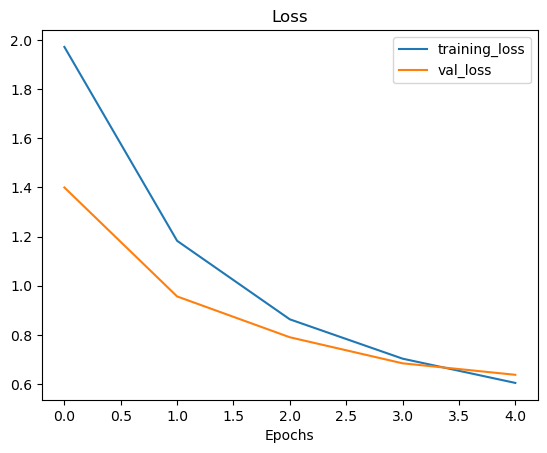

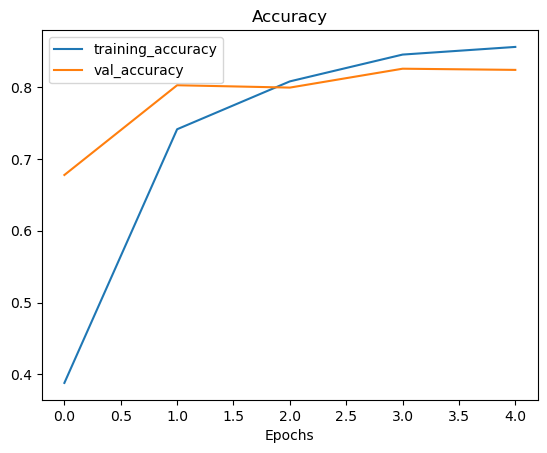

In [17]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)